### FIGURE 3 - Clasen et al

In [43]:
import pandas as pd
import plotly.express as px
from collections import defaultdict
import plotly
import seaborn as sns
from math import log2

In [2]:
def getCarbonCount(comp):
    if 'C' in comp:
        if 'H' in comp:
            carbon = comp.split('H')[0].replace('C','')
            try:
                carbon = int(carbon)
            except ValueError:
                carbon = 1
        else:
            carbon = 1
    else:
        carbon = 0 
    return carbon

In [3]:
def setPlotFont(fig):
    fig = fig.update_layout(font=dict(size=12,family='Arial',color="black"))
    return fig

In [4]:
def influx(diet_df,models,groups):
    skip =  ['starch structure 2[s]','O2[s]','sucrose[s]']
    d = []
    for model in models:
        total = 0
        counts = {}
        for group in groups:
            count = 0
            sub_df = diet_df[diet_df['Group'] == group]
            for index,row in sub_df.iterrows():
                if str(row['Metabolite']) not in skip:
                    carbon = row['Composition'].split('H')[0].replace('C','')
                    moleFlux = float(carbon) * float(row[model])
                    count += moleFlux
            counts[group] = count
        for count in counts:
            ratio = counts[count]
            d.append({'Model' : 'IN_'+model,
                      'Group' : count,
                      'Cmoles' : ratio})
    df = pd.DataFrame(d)
    return df

In [5]:
def efflux(fba,mets_df,models):
    composition = dict(zip(mets_df.index,mets_df['COMPOSITION']))
    composition['LDL[s]'] = 'C36720H2XXX'
    biomassC = {}
    otherC = defaultdict(dict)
    Cin = defaultdict(dict)
    fluxIn = defaultdict(dict)
    fluxOut = defaultdict(dict)
    modelTotals = {}
    for model in models:
        carbonIn = 0
        carbonOut = 0
        for index,row in fba.iterrows():
            if index == 'HMR_5265':
                apoBFlux = row[model]
            if row['SUBSYSTEM'] == 'Exchange reactions' and row[model] != 0:
                if '_IN_' in index:
                    met = row['EQUATION'].replace(' => ','').strip()
                    c = getCarbonCount(str(composition[met]))
                    carbonIn += abs(row[model]) * c
                    fluxIn[model][met] = abs(row[model])
                elif '_OUT_' in index:
                    met = row['EQUATION'].replace(' => ','').strip()
                    c = getCarbonCount(str(composition[met]))
                    carbonOut += abs(row[model]) * c
                    fluxOut[model][met] = abs(row[model])
                    if met != 'CO2[s]':
                        otherC[model][met] = abs(row[model]) * c
                elif '_BOTH_' in index:    
                    met = row['EQUATION'].replace(' <=> ','').strip()
                    c = getCarbonCount(str(composition[met]))
                    if row[model] < 0:
                        carbonOut += abs(row[model]) * c
                        otherC[model][met] = abs(row[model]) * c
                        fluxOut[model][met] = abs(row[model])
                    elif row[model] > 0:
                        carbonIn += abs(row[model]) * c
                        fluxIn[model][met] = abs(row[model])
                    else:
                        print(met)
                else:
                    print('CHECK!!!!') 
                #if c == 0 :
                #    print(met)
        carbonIn += apoBFlux * 22282
        netcarbon = carbonIn - carbonOut
        biomassC[model] = netcarbon
        modelTotals[model] = carbonIn
    CO2 = {}
    for model in models:
        CO2[model] = fba.at['EXC_OUT_C00011[s]',model]
    d = []
    for model in biomassC:
        modelName = 'OUT_'+model
        d.append({'Model' : modelName,
                  'Cmoles' : biomassC[model], 
                  'Metabolite' : 'biomass',
                  'Group' : 'Biomass'})
        d.append({'Model' : modelName,
                  'Cmoles' : CO2[model], 
                  'Metabolite' : 'CO2',
                  'Group' : 'CO2'})
        for met in otherC[model]:
            if 'glycerol' in met:
                d.append({'Model' : modelName,
                          'Cmoles' : otherC[model][met], 
                          'Metabolite' : met,
                          'Group' : 'glycerol'})
            elif 'succinate' in met: 
                d.append({'Model' : modelName,
                          'Cmoles' : otherC[model][met], 
                          'Metabolite' : met,
                          'Group' : 'succinate'})
            else:
                d.append({'Model' : modelName,
                          'Cmoles' : otherC[model][met], 
                          'Metabolite' : met,
                          'Group' : 'Other metabolites'})
    df = pd.DataFrame(d)
    return df

In [6]:
def plotBarPlot(df):
    cols = plotly.colors.qualitative.Pastel[0:7] 
    fig = px.bar(df,x = 'Model',y = 'Cmoles',color= 'Group',template = 'none',
                 category_orders={"Group": ['Carbohydrate','Lipid','Amino Acid','Sink reactions',
                                            'Biomass','CO2','glycerol','succinate','Other metabolites']},
                 color_discrete_sequence=[cols[1],cols[2],cols[3],cols[6],
                                          'rgb(0,0,0)', 'rgb(82,82,82)', 'rgb(150,150,150)', 'rgb(189,189,189)',
                                          'rgb(230,230,230)'])
    fig.update_layout(autosize = False,width = 800,height = 300,
                      xaxis_title='',yaxis_title='Carbon flux (mmol/mouse/day)',
                      margin=dict(l=50,r=20,b=20,t=20,pad=4))
    fig = setPlotFont(fig)
    fig.update_layout(legend_traceorder="reversed")
    fig.update_xaxes(showticklabels=False)
    return fig 

In [7]:
def plotBarPlotOthers(df):
    others = df[df['Group'] == 'Other metabolites']
    for index,row in others.iterrows():
        if row['Cmoles'] <= 1:
            others.at[index,'other_group'] = 'Small'
        else:
            others.at[index,'other_group'] = row['Metabolite']
    fig = px.bar(others,x = 'Model',y = 'Cmoles',color= 'other_group',template = 'none',
                 color_discrete_sequence = plotly.colors.qualitative.Light24_r,)
    fig.update_layout(autosize = False,width = 500,height = 450,
                      xaxis_title='',yaxis_title='Carbon flux (mmol/mouse/day)',
                      margin=dict(l=50,r=20,b=20,t=20,pad=4))
    fig = setPlotFont(fig)
    fig.update_layout(legend_traceorder="reversed")
    fig.update_xaxes(showticklabels=False)
    return fig

FOR FIGURE 3C

In [15]:
def getSignificantFluxes(fba,models):
    selectIndexes = []
    for index,row in fba.iterrows():
        l = []
        for model in models:
            l.append(abs(round(row[model],3)))
            if any(x >= 0.001 for x in l) == True:
                selectIndexes.append(index)
            else:
                pass
    selectIndexes = list(set(selectIndexes))
    sub_df = fba.loc[selectIndexes]
    for index,row in sub_df.iterrows():
        for model in models:
            sub_df.at[index,model] = round(row[model],3)
    return sub_df

In [16]:
def differentialFlux(fba,model1,model2):
    FBA = getSignificantFluxes(fba,[model1,model2])
    rxns = []
    for index,row in FBA.iterrows():
        if row[model1] != 0 or row[model2] != 0:
            if row[model1] != row[model2]:
                rxns.append(index)
    return rxns

In [28]:
def generateHeatmapData(WT,MUTS,index):
    x = ['WD_nonDEN_Liver_WD','WD_nonDEN_Liver_CD','WD_DEN_Liver_CD','WD_DEN_AdjLiver_WD','WD_DEN_Tumour_WD']
    y = list(MUTS.keys())
    outdf = pd.DataFrame(index=y,columns=x)
    for row in y:
        for col in x:
            ratio = MUTS[row].at[index,col] / WT.at[index,col]
            outdf.at[row,col] = ratio
    outdf = outdf.astype('float')
    fig = sns.clustermap(outdf,row_cluster=False,col_cluster=False,cmap="vlag",center=1)
    return fig

FOR FIGURE 3D

In [52]:
def fluxFolds(fba,modelPairs):
    d = []
    for model in modelPairs:
        sig_df = getSignificantFluxes(fba,modelPairs[model])
        for index,row in sig_df.iterrows():
            WD = abs(row[modelPairs[model][0]])
            CD = abs(row[modelPairs[model][1]])
            if WD != CD:
                fc = (WD+0.1)/(CD+0.1)
                lfc = log2(fc)
                d.append({'Rxn':index,'Equation':row['EQUATION'],'Model' : model,'logFC' : lfc})
    df = pd.DataFrame(d)
    df = df.sort_values(by=['logFC'])
    return df

### Dataframes import

In [53]:
fba = pd.read_excel('../Supplementary Tables.xlsx',sheet_name='Table S3',index_col='ID')
diet_df = pd.read_excel('../Supplementary Tables.xlsx',sheet_name = 'Table S2')
mets_df = pd.read_excel('../data/models/xlsx/genericLiverWD.xlsx',sheet_name = 'METS',index_col = 'ID')

## FIGURE 3B

In [9]:
INMODELS = ['CD','WD',
           'genericCD','genericWD',
           'CD_nonDEN_Liver_CD','CD_nonDEN_Liver_WD','CD_DEN_Liver_CD','CD_DEN_AdjLiver_WD','CD_DEN_Tumour_WD',
           'WD_nonDEN_Liver_CD','WD_nonDEN_Liver_WD','WD_DEN_Liver_CD','WD_DEN_AdjLiver_WD','WD_DEN_Tumour_WD']
groups = ['Carbohydrate','Lipid','Amino Acid']
INFLUX = influx(diet_df,INMODELS,groups)
OUTMODELS = INMODELS[2:]
EFFLUX = efflux(fba,mets_df,OUTMODELS)
FINAL = pd.concat([INFLUX,EFFLUX],axis=0)
fig = plotBarPlot(FINAL)
fig.write_image('Figure3B.pdf')

## FIGURE S3B

In [10]:
## LEFT HAND SIDE WITH SINK REACTIONS
INMODELS = ['CD','WD',
            'genericCD','genericWD',
           'CD_nonDEN_Liver_CD','CD_nonDEN_Liver_WD','CD_DEN_Liver_CD','CD_DEN_AdjLiver_WD','CD_DEN_Tumour_WD',
           'WD_nonDEN_Liver_CD','WD_nonDEN_Liver_WD','WD_DEN_Liver_CD','WD_DEN_AdjLiver_WD','WD_DEN_Tumour_WD']
groups = ['Carbohydrate','Lipid','Amino Acid','Sink reactions']
INFLUX = influx(diet_df,INMODELS,groups)
OUTMODELS = INMODELS[2:]
EFFLUX = efflux(fba,mets_df,OUTMODELS)
FINAL = pd.concat([INFLUX,EFFLUX],axis=0)
fig = plotBarPlot(FINAL)
fig.write_image('FigureS3B_1.pdf')

# OTHER METABOLITES
fig = plotBarPlotOthers(FINAL)
fig.write_image('FigureS3B_2.pdf')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## FIGURE 3C

In [37]:
path = '/Volumes/lab-anastasioud/home/users/clasenf/conditionModels/FBA/FBAExperiments.xlsx'
component_switch = {'All' : 'BiomassAll',
                    'Carbohydates' : 'BiomassCarbs',
                    'Lipids' : 'BiomassLipid',
                    'AAs' : 'BiomassAA',
                    'CarbsLipids' : 'BiomassCarbsLipids',
                    'CarbsAAs' : 'BiomassCarbsAAs',
                    'LipidsAAs' : 'BiomassAAsLipids'}
carb_switch = {'noCarb' : 'noCarb',
               'glucose' : 'glucose',
               'fructose' : 'fructose',
               'GlucFruc' : 'glucosefructose'}
component_d = {}
for sheet in component_switch:
    df = pd.read_excel(path,sheet_name=component_switch[sheet],index_col='ID')
    component_d[sheet] = df
    
carb_d = {}
for sheet in carb_switch:
    df = pd.read_excel(path,sheet_name=carb_switch[sheet],index_col='ID')
    carb_d[sheet] = df

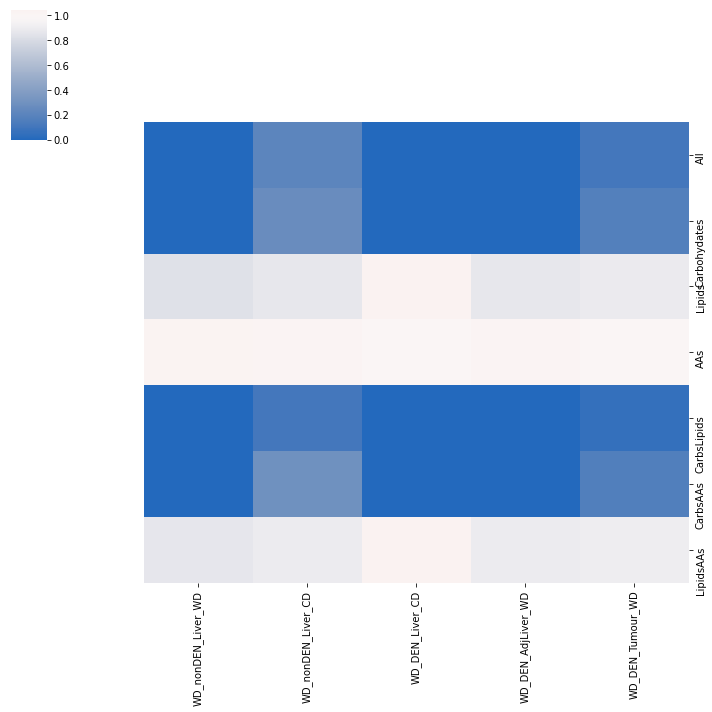

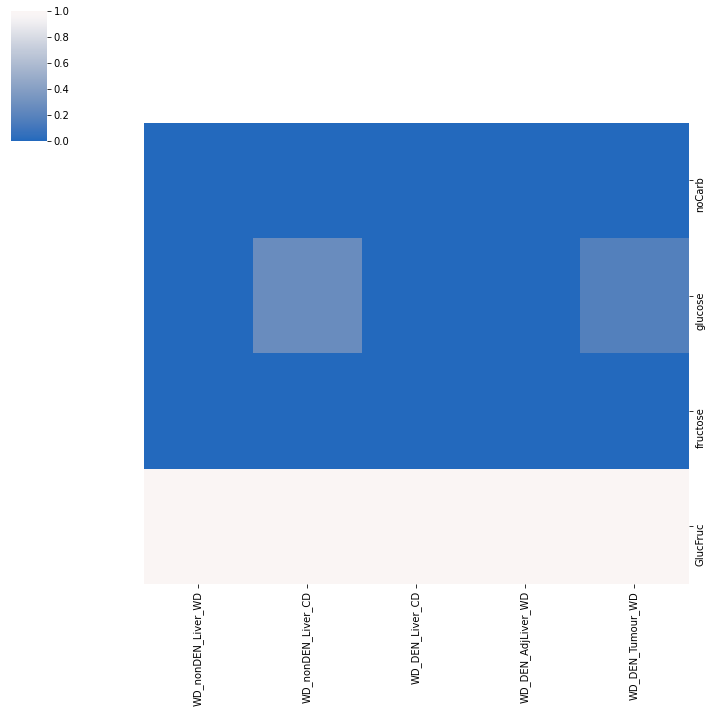

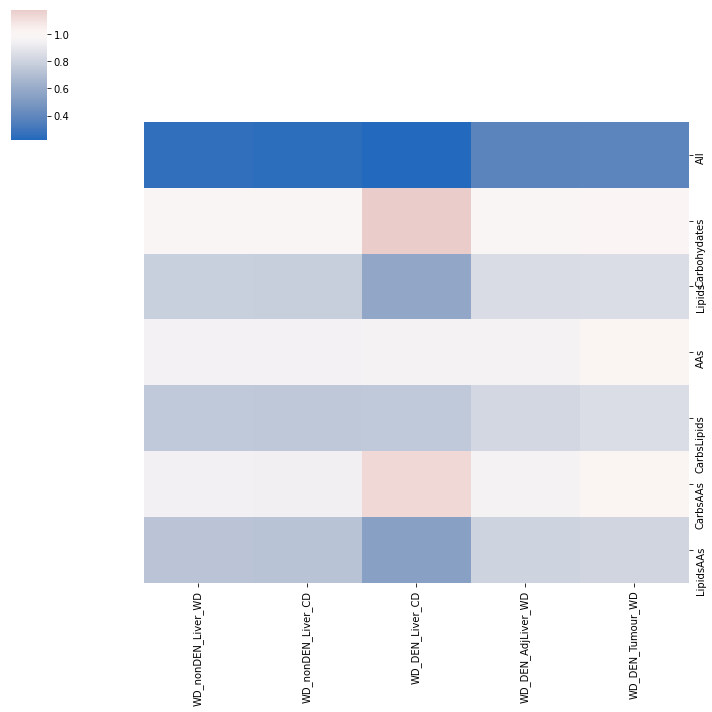

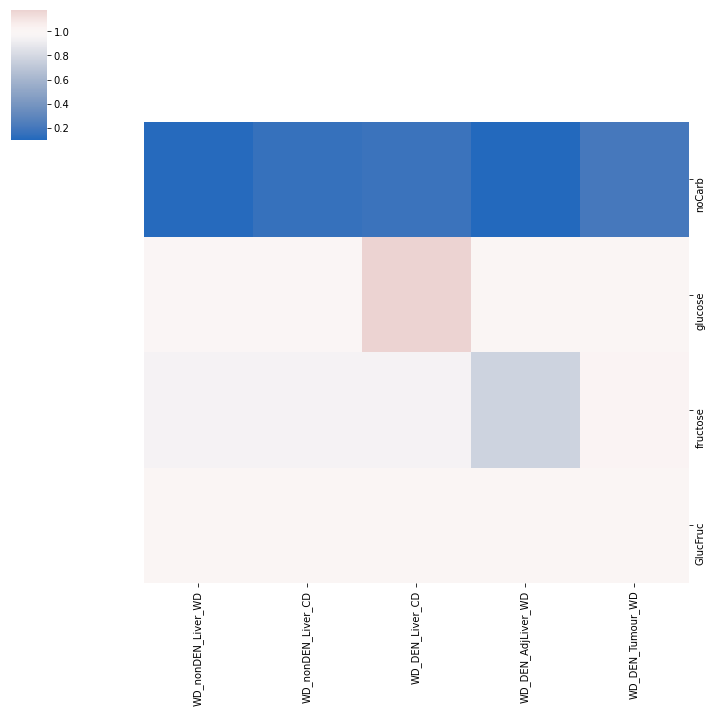

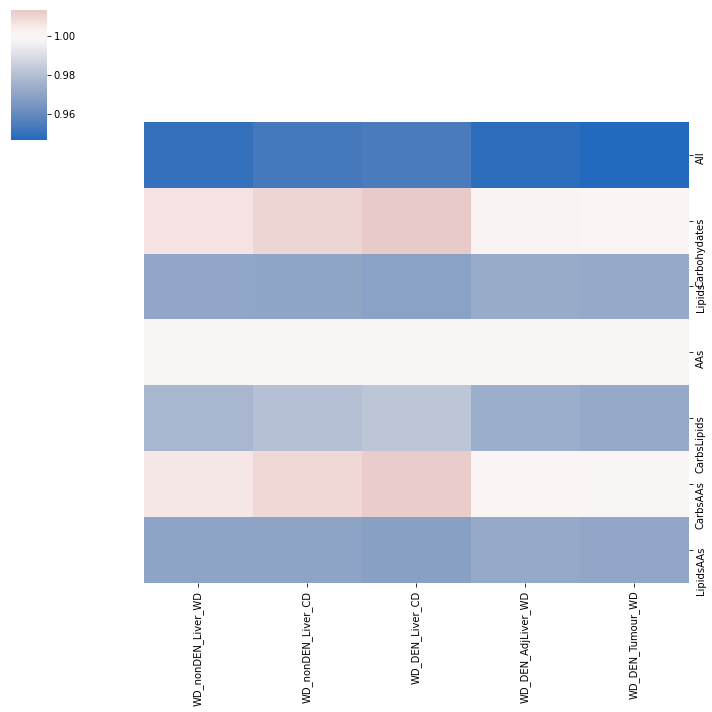

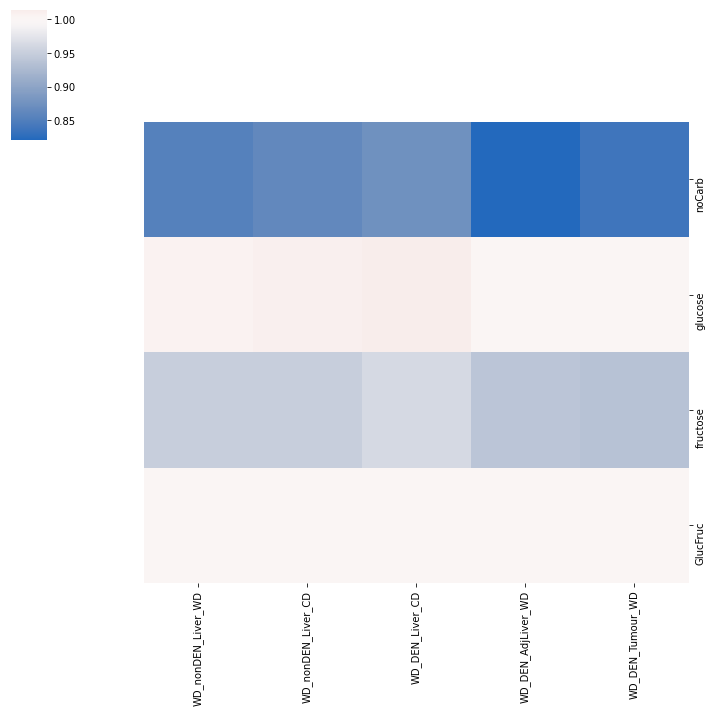

In [38]:
for index,row in fba.iterrows():
    if 'biomass[s]' in row['EQUATION'] and row['SUBSYSTEM'] == 'Exchange reactions':
        fig = generateHeatmapData(fba,component_d,index)
        fig.savefig('Figure3C_1.pdf')
        fig = generateHeatmapData(fba,carb_d,index)
        fig.savefig('Figure3C_2.pdf')
        
    if '<=> glycerol[s]' in row['EQUATION'] and row['SUBSYSTEM'] == 'Exchange reactions':
        fig = generateHeatmapData(fba,component_d,index)
        fig.savefig('Figure3C_3.pdf')
        fig = generateHeatmapData(fba,carb_d,index)
        fig.savefig('Figure3C_4.pdf')
        
    if '<=> succinate[s]' in row['EQUATION'] and row['SUBSYSTEM'] == 'Exchange reactions':
        fig = generateHeatmapData(fba,component_d,index)
        fig.savefig('Figure3C_5.pdf')
        fig = generateHeatmapData(fba,carb_d,index)
        fig.savefig('Figure3C_6.pdf')

## FIGURE 3D

In [56]:
modelPairs = {'nonDEN_Liver_CD' : ['WD_nonDEN_Liver_CD','CD_nonDEN_Liver_CD'],
              'nonDEN_Liver_WD' : ['WD_nonDEN_Liver_WD','CD_nonDEN_Liver_WD'],
              'DEN_Liver_CD'    : ['WD_DEN_Liver_CD','CD_DEN_Liver_CD'],
              'DEN_AdjLiver_WD' : ['WD_DEN_AdjLiver_WD','CD_DEN_AdjLiver_WD'],
              'DEN_Tumour_WD'   : ['WD_DEN_Tumour_WD','CD_DEN_Tumour_WD']}
df = fluxFolds(fba,modelPairs)
df = df[abs(df['logFC']) >= 1.5]
rxns = list(set(df['Rxn']))
fout = open('Figure3DRxns.txt','w')
fout.write('\n'.join(rxns))
fout.close()